<a href="https://colab.research.google.com/github/Priyashree1312/Sriya.AI-/blob/main/financial_fraud_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
df = pd.read_csv("credcardfrd50k.csv")
print(df.shape)           # Show number of rows, columns
print(df.head(3))         # Quick look at your data


(50000, 381)
   TransactionID  isFraud  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0         130196        0             0           94500.0    180000.0   
1         277776        0             1          108000.0    227520.0   
2         231918        0             0          166500.0    490500.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       9000.0         180000.0                    0.008575      -19671   
1      16618.5         180000.0                    0.009630      -12947   
2      30136.5         490500.0                    0.015221      -23013   

   DAYS_EMPLOYED  ...   ERC20 most sent token type_0  \
0          -9266  ...                              0   
1          -1933  ...                              0   
2         365243  ...                              0   

    ERC20 most sent token type_EOS   ERC20 most sent token type_Golem  \
0                                0                                  0   
1                     

In [ ]:
features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED'
]
label = 'isFraud'


In [ ]:
df = df.dropna(subset=features + [label])
print("Shape after removing missing values:", df.shape)


Shape after removing missing values: (50000, 381)


In [ ]:
group_size = 5    # Number of transactions per artificial user session
df['user_id'] = df.index // group_size


In [ ]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


In [ ]:
sequence_length = 3
X_seq, y_seq = [], []

for _, user_df in df.groupby('user_id'):
    if len(user_df) < sequence_length:
        continue
    arr = user_df[features].values
    lbl = user_df[label].values
    for i in range(len(arr) - sequence_length):
        X_seq.append(arr[i:i+sequence_length])
        y_seq.append(lbl[i+sequence_length - 1])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)


In [ ]:
print(f"Total sequences: {len(X_seq)}")
print(f"Fraudulent examples: {np.sum(y_seq)}")
print(f"Normal examples: {len(y_seq) - np.sum(y_seq)}")


Total sequences: 20000
Fraudulent examples: 1633
Normal examples: 18367


In [ ]:
# Group every 5 sequential transactions into a synthetic "user"
group_size = 5
df['user_id'] = df.index // group_size
total_users = df['user_id'].nunique()
print("Synthetic users created:", total_users)


Synthetic users created: 10000


In [ ]:
# Normalize using StandardScaler
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
print("✅ Features normalized.")


✅ Features normalized.


In [ ]:
# Set LSTM sequence length
sequence_length = 3

# Prepare lists for sequences and labels
X_seq, y_seq = [], []

# Group data by user sessions
for _, group in df.groupby('user_id'):
    if len(group) < sequence_length:
        continue  # skip short sessions
    X_values = group[features].values
    y_values = group[label].values
    for i in range(len(X_values) - sequence_length):
        X_seq.append(X_values[i:i + sequence_length])
        y_seq.append(y_values[i + sequence_length - 1])  # label of last item in sequence

# Convert to NumPy arrays
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"✅ Final LSTM data shape: {X_seq.shape}")
print(f"✅ Fraud samples: {np.sum(y_seq)} / {len(y_seq)} total")
unique, counts = np.unique(y_seq, return_counts=True)
print("✅ Class distribution:", dict(zip(unique, counts)))


✅ Final LSTM data shape: (20000, 3, 8)
✅ Fraud samples: 1633 / 20000 total
✅ Class distribution: {np.int64(0): np.int64(18367), np.int64(1): np.int64(1633)}


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.utils import set_random_seed
import tensorflow as tf

# (Assume X_train, X_test, y_train, y_test already come from your preprocessing code)

set_random_seed(42)
np.random.seed(42)

model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from sklearn.utils import class_weight

# Compute class weights using y_train
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))

# Train the LSTM model with class weights
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4237 - loss: 0.6933 - val_accuracy: 0.5825 - val_loss: 0.6692
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5358 - loss: 0.6801 - val_accuracy: 0.5913 - val_loss: 0.6558
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5543 - loss: 0.6738 - val_accuracy: 0.6050 - val_loss: 0.6527
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5650 - loss: 0.6685 - val_accuracy: 0.6150 - val_loss: 0.6494
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5672 - loss: 0.6673 - val_accuracy: 0.6169 - val_loss: 0.6496
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5781 - loss: 0.6649 - val_accuracy: 0.6106 - val_loss: 0.6516
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5747 - loss: 0.6664 - val_accuracy: 0.6187 - val_loss: 0.6530
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5794 - loss: 0.6625 - val_accura

In [ ]:
from imblearn.over_sampling import SMOTE

# Flatten sequences for SMOTE
X_flat = X_train.reshape((X_train.shape[0], -1))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_flat, y_train)
X_res = X_res.reshape((-1, X_train.shape[1], X_train.shape[2]))

# Train LSTM with resampled data (optionally, skip class_weight here)
history = model.fit(
    X_res, y_res,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6168 - loss: 0.6488 - val_accuracy: 0.5243 - val_loss: 0.7352
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6315 - loss: 0.6374 - val_accuracy: 0.5512 - val_loss: 0.7233
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6497 - loss: 0.6235 - val_accuracy: 0.5975 - val_loss: 0.6950
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6652 - loss: 0.6070 - val_accuracy: 0.6373 - val_loss: 0.6732
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6826 - loss: 0.5905 - val_accuracy: 0.6812 - val_loss: 0.6411
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6935 - loss: 0.5773 - val_accuracy: 0.7030 - val_loss: 0.6195
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7038 - loss: 0.5638 - val_accuracy: 0.7155 - val_loss: 0.6054
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7150 - loss: 0.5476 - val_accuracy: 

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy : 0.7278
Precision: 0.1015
Recall   : 0.2966
F1-score : 0.1512
MSE      : 0.176374
MAE      : 0.337477
RMSE     : 0.419969
R²       : -1.3496


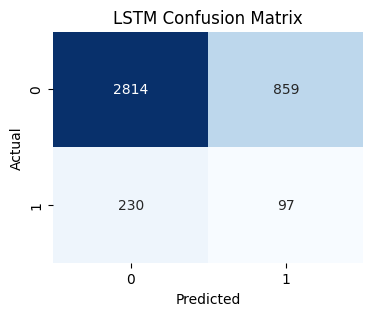

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
probs = model.predict(X_test).ravel()
preds = (probs > 0.5).astype(int)

print(f"Accuracy : {accuracy_score(y_test, preds):.4f}")
print(f"Precision: {precision_score(y_test, preds, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, preds, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, preds):.4f}")
print(f"MSE      : {mean_squared_error(y_test, probs):.6f}")
print(f"MAE      : {mean_absolute_error(y_test, probs):.6f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_test, probs)):.6f}")
print(f"R²       : {r2_score(y_test, probs):.4f}")

# (Optionally remove MAPE for binary classification as it's not meaningful)
# Confusion matrix visualization
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Class weights: {0: np.float64(0.5444399074452158), 1: np.float64(6.1255742725880555)}
Class balance train set: [14694  1306]
Epoch 1/20
113/113 - 6s - 53ms/step - accuracy: 0.4747 - auc: 0.5665 - loss: 0.6897 - val_accuracy: 0.5719 - val_auc: 0.6098 - val_loss: 0.6677
Epoch 2/20
113/113 - 2s - 18ms/step - accuracy: 0.5276 - auc: 0.5930 - loss: 0.6825 - val_accuracy: 0.5531 - val_auc: 0.6299 - val_loss: 0.6635
Epoch 3/20
113/113 - 1s - 11ms/step - accuracy: 0.5200 - auc: 0.6054 - loss: 0.6780 - val_accuracy: 0.5881 - val_auc: 0.6405 - val_loss: 0.6503
Epoch 4/20
113/113 - 1s - 10ms/step - accuracy: 0.5426 - auc: 0.6149 - loss: 0.6755 - val_accuracy: 0.5925 - val_auc: 0.6469 - val_loss: 0.6533
Epoch 5/20
113/113 - 1s - 12ms/step - accuracy: 0.5456 - auc: 0.6194 - loss: 0.6733 - val_accuracy: 0.6019 - val_auc: 0.6503 - val_loss: 0.6492
Epoch 6/20
113/113 - 1s - 11ms/step - accuracy: 0.5557 - auc: 0.6229 - loss: 0.6722 - val_accuracy: 0.6106 - val_auc: 0.6521 - val_loss: 0.6511
Epoch 7/20


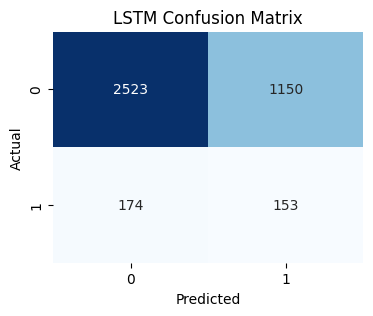

In [ ]:
# --- 1. IMPORTS ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")


# --- 2. DATA PREPARATION ---
df = pd.read_csv("credcardfrd50k.csv")
features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED'
]
label = 'isFraud'

# Clean missing
df = df.dropna(subset=features + [label])

# Simulate user sessions
group_size = 5
df['user_id'] = df.index // group_size

# Normalize
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Sequence builder
sequence_length = 3
X_seq, y_seq = [], []
for _, user_df in df.groupby('user_id'):
    if len(user_df) < sequence_length:
        continue
    arr = user_df[features].values
    lbl = user_df[label].values
    for i in range(len(arr) - sequence_length):
        X_seq.append(arr[i:i+sequence_length])
        y_seq.append(lbl[i+sequence_length - 1])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

# --- 3. HANDLE IMBALANCE: CLASS WEIGHT ---
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
cw_dict = dict(enumerate(cw))
print("Class weights:", cw_dict)
print("Class balance train set:", np.bincount(y_train.astype(int)))


# --- 4. LSTM MODEL ---
model = Sequential([
    Masking(mask_value=0., input_shape=(sequence_length, len(features))),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    class_weight=cw_dict,
    verbose=2
)


# --- 5. EVALUATION AND THRESHOLD TUNING ---
probs = model.predict(X_test).ravel()

# Try different thresholds and report metrics for best F1
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0
best_thresh = 0.5
for t in thresholds:
    pred = (probs > t).astype(int)
    f1 = f1_score(y_test, pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
print(f"\nBest threshold by F1: {best_thresh:.2f} (F1={best_f1:.4f})")

# Use best threshold
preds = (probs > best_thresh).astype(int)

# --- 6. METRICS ---
print("\n=== LSTM Model Metrics (Optimized for F1) ===")
print(f"Accuracy : {accuracy_score(y_test, preds):.4f}")
print(f"Precision: {precision_score(y_test, preds, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, preds, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, preds):.4f}")
print(f"AUC      : {roc_auc_score(y_test, probs):.4f}")
print(f"AvgPrec  : {average_precision_score(y_test, probs):.4f}")
mse  = mean_squared_error(y_test, probs)
mae  = mean_absolute_error(y_test, probs)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, probs)
print(f"MSE      : {mse:.6f}")
print(f"MAE      : {mae:.6f}")
print(f"RMSE     : {rmse:.6f}")
print(f"R² Score : {r2:.4f}")

# --- 7. CONFUSION MATRIX ---
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# PARAMETERS
RANDOM_SEED = 42
GROUP_SIZE = 10        # Must be > SEQUENCE_LENGTH
SEQUENCE_LENGTH = 5
ROLLING_FEATURES = True
EPOCHS = 40
BATCH_SIZE = 128


In [ ]:
df = pd.read_csv('credcardfrd50k.csv')

# Base features
features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED'
]
label = 'isFraud'

# Advanced feature engineering: rolling mean/std, ratios
if ROLLING_FEATURES:
    for col in features:
        df[f'{col}_mean3'] = df[col].rolling(3, min_periods=1).mean()
        df[f'{col}_std3'] = df[col].rolling(3, min_periods=1).std().fillna(0)
    df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1e-6)
    df['GOODS_CREDIT_RATIO'] = df['AMT_GOODS_PRICE'] / (df['AMT_CREDIT'] + 1e-6)
    extra_features = [f"{col}_mean3" for col in features] + [f"{col}_std3" for col in features] + [
        'CREDIT_INCOME_RATIO', 'GOODS_CREDIT_RATIO'
    ]
    all_features = features + extra_features
else:
    all_features = features

# Remove incomplete records
df = df.dropna(subset=all_features + [label])

# Normalize
scaler = StandardScaler()
df[all_features] = scaler.fit_transform(df[all_features])

# Grouping: Each synthetic user/session is GROUP_SIZE transactions
if GROUP_SIZE <= SEQUENCE_LENGTH:
    raise ValueError("GROUP_SIZE must be greater than SEQUENCE_LENGTH!")
df['user_id'] = df.index // GROUP_SIZE

# Build LSTM sequences
X_seq, y_seq = [], []
for _, user_df in df.groupby('user_id'):
    vals = user_df[all_features].values
    labs = user_df[label].values
    # Ensure we have enough data per group
    if len(vals) < (SEQUENCE_LENGTH + 1):
        continue
    for i in range(len(vals) - SEQUENCE_LENGTH):
        X_seq.append(vals[i:i+SEQUENCE_LENGTH])
        y_seq.append(labs[i+SEQUENCE_LENGTH-1])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"✅ LSTM sequence shape: {X_seq.shape}, Fraud: {np.sum(y_seq)}, Non-fraud: {len(y_seq) - np.sum(y_seq)}")

if len(X_seq) == 0:
    raise ValueError("No valid LSTM sequences. Increase GROUP_SIZE or decrease SEQUENCE_LENGTH.")


✅ LSTM sequence shape: (25000, 5, 26), Fraud: 2005, Non-fraud: 22995


In [ ]:
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

model = Sequential([
    Masking(mask_value=0., input_shape=(SEQUENCE_LENGTH, X_train.shape[2])),
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    X_res, y_res,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    class_weight=cw_dict,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/40
196/196 - 13s - 65ms/step - accuracy: 0.4556 - auc: 0.5468 - loss: 1.3947 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.2625
Epoch 2/40
196/196 - 5s - 27ms/step - accuracy: 0.4180 - auc: 0.6146 - loss: 0.9847 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.1116
Epoch 3/40
196/196 - 5s - 25ms/step - accuracy: 0.4215 - auc: 0.6481 - loss: 0.9599 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0900
Epoch 4/40
196/196 - 2s - 13ms/step - accuracy: 0.4282 - auc: 0.6689 - loss: 0.9427 - val_accuracy: 0.9998 - val_auc: 0.0000e+00 - val_loss: 0.0930
Epoch 5/40
196/196 - 3s - 13ms/step - accuracy: 0.4342 - auc: 0.6896 - loss: 0.9258 - val_accuracy: 0.9998 - val_auc: 0.0000e+00 - val_loss: 0.0906
Epoch 6/40
196/196 - 4s - 18ms/step - accuracy: 0.4412 - auc: 0.7042 - loss: 0.9123 - val_accuracy: 0.9995 - val_auc: 0.0000e+00 - val_loss: 0.0875
Epoch 7/40
196/196 - 3s - 13ms/step - accuracy: 0.4476 - auc: 0.7179 - loss: 0.8982 - val_accuracy: 0.9998 - va

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Best threshold for F1: 0.70 (F1: 0.1651)

**** FINAL METRICS, THRESHOLD OPTIMIZED ****
Accuracy : 0.4918
Precision: 0.0954
Recall   : 0.6147
F1-score : 0.1651
ROC-AUC  : 0.5615
PR-AUC   : 0.1050
MSE      : 0.461191
MAE      : 0.582054
RMSE     : 0.679110
R² Score : -5.1437


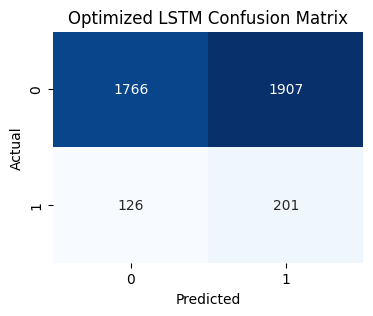

In [ ]:
probs = model.predict(X_test).ravel()
roc = roc_auc_score(y_test, probs)
prc = average_precision_score(y_test, probs)
thresholds = np.linspace(0.1, 0.9, 17)
best_f1, best_thresh = 0, 0.5
for t in thresholds:
    p = (probs > t).astype(int)
    f1 = f1_score(y_test, p)
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

print(f"\nBest threshold for F1: {best_thresh:.2f} (F1: {best_f1:.4f})")
preds = (probs > best_thresh).astype(int)

print("\n**** FINAL METRICS, THRESHOLD OPTIMIZED ****")
print(f"Accuracy : {accuracy_score(y_test, preds):.4f}")
print(f"Precision: {precision_score(y_test, preds, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, preds, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, preds):.4f}")
print(f"ROC-AUC  : {roc:.4f}")
print(f"PR-AUC   : {prc:.4f}")
print(f"MSE      : {mean_squared_error(y_test, probs):.6f}")
print(f"MAE      : {mean_absolute_error(y_test, probs):.6f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_test, probs)):.6f}")
print(f"R² Score : {r2_score(y_test, probs):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Optimized LSTM Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight, resample
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Parameters
RANDOM_SEED = 42
GROUP_SIZE = 20          # Substantially more transactions per synthetic session
SEQUENCE_LENGTH = 7      # Longer transaction window
EPOCHS = 40
BATCH_SIZE = 128


In [ ]:
df = pd.read_csv('credcardfrd50k.csv')

features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED'
]
label = 'isFraud'

df = df.dropna(subset=features + [label])

# Add surrogate user sessions
df['user_id'] = df.index // GROUP_SIZE

# Normalize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Build sequences
X_seq, y_seq = [], []
for _, user_df in df.groupby('user_id'):
    arr = user_df[features].values
    labs = user_df[label].values
    if len(arr) < (SEQUENCE_LENGTH + 1):
        continue
    for i in range(len(arr) - SEQUENCE_LENGTH):
        X_seq.append(arr[i:i+SEQUENCE_LENGTH])
        y_seq.append(labs[i+SEQUENCE_LENGTH-1])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print(f"Sequences built: {X_seq.shape[0]}, Fraud: {y_seq.sum()} / Non-fraud: {len(y_seq)-y_seq.sum()}")


Sequences built: 32500, Fraud: 2631 / Non-fraud: 29869


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=RANDOM_SEED
)


In [ ]:
# Flatten for ADASYN, then reshape after
X_flat = X_train.reshape(X_train.shape[0], -1)
ada = ADASYN(random_state=RANDOM_SEED)
X_ada, y_ada = ada.fit_resample(X_flat, y_train)
X_ada = X_ada.reshape(-1, SEQUENCE_LENGTH, X_train.shape[2])
print("After ADASYN:", np.bincount(y_ada.astype(int)))


After ADASYN: [23895 23289]


In [ ]:
# ➕ Step 1: Flatten X_ada for manipulation
n_samples = X_ada.shape[0]
X_flat_for_balance = X_ada.reshape(n_samples, -1)  # (samples, timesteps * features)

# ➕ Step 2: Attach labels to X as 2D
Xy = np.hstack([X_flat_for_balance, y_ada.reshape(-1, 1)])  # Now shape = (samples, features + 1)

# ➕ Step 3: Separate fraud (1) and non-fraud (0)
fraud = Xy[Xy[:, -1] == 1]
nonfraud = Xy[Xy[:, -1] == 0]

# 🔁 Undersample non-fraud to match fraud count
nonfraud_sampled = resample(nonfraud, n_samples=len(fraud), random_state=RANDOM_SEED)

# 🧱 Combine balanced data
balanced = np.vstack([fraud, nonfraud_sampled])
np.random.shuffle(balanced)

# ➕ Step 4: Separate X and y from balanced set
X_bal_2d = balanced[:, :-1]  # Remove label
y_bal = balanced[:, -1]

# Reshape X to (samples, timesteps, features)
X_bal = X_bal_2d.reshape(-1, SEQUENCE_LENGTH, X_train.shape[2])

# 🔍 Confirm shapes
print("✅ After undersampling:", np.bincount(y_bal.astype(int)))


✅ After undersampling: [23289 23289]


In [ ]:
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_bal),
    y=y_bal
)
cw_dict = dict(enumerate(cw))


In [ ]:
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

model = Sequential([
    Masking(mask_value=0., input_shape=(SEQUENCE_LENGTH, X_bal.shape[2])),
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    X_bal, y_bal,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.15,
    class_weight=cw_dict,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/40
310/310 - 18s - 59ms/step - accuracy: 0.6271 - auc: 0.6746 - loss: 0.6498 - val_accuracy: 0.6734 - val_auc: 0.7886 - val_loss: 0.6113
Epoch 2/40
310/310 - 9s - 31ms/step - accuracy: 0.7294 - auc: 0.8025 - loss: 0.5379 - val_accuracy: 0.7780 - val_auc: 0.8545 - val_loss: 0.4729
Epoch 3/40
310/310 - 9s - 28ms/step - accuracy: 0.7675 - auc: 0.8437 - loss: 0.4795 - val_accuracy: 0.7900 - val_auc: 0.8725 - val_loss: 0.4429
Epoch 4/40
310/310 - 8s - 25ms/step - accuracy: 0.7845 - auc: 0.8620 - loss: 0.4518 - val_accuracy: 0.8002 - val_auc: 0.8834 - val_loss: 0.4250
Epoch 5/40
310/310 - 12s - 39ms/step - accuracy: 0.7956 - auc: 0.8726 - loss: 0.4347 - val_accuracy: 0.8095 - val_auc: 0.8923 - val_loss: 0.4076
Epoch 6/40
310/310 - 10s - 31ms/step - accuracy: 0.8039 - auc: 0.8819 - loss: 0.4199 - val_accuracy: 0.8127 - val_auc: 0.8977 - val_loss: 0.4001
Epoch 7/40
310/310 - 7s - 22ms/step - accuracy: 0.8083 - auc: 0.8870 - loss: 0.4110 - val_accuracy: 0.8232 - val_auc: 0.9054 - val_lo

204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Best threshold for F1: 0.10 (F1: 0.1743)

**** FINAL METRICS, THRESHOLD OPTIMIZED ****
Accuracy : 0.6546
Precision: 0.1081
Recall   : 0.4506
F1-score : 0.1743
ROC-AUC  : 0.5854
PR-AUC   : 0.1032
MSE      : 0.106088
MAE      : 0.182253
RMSE     : 0.325711
R² Score : -0.4264


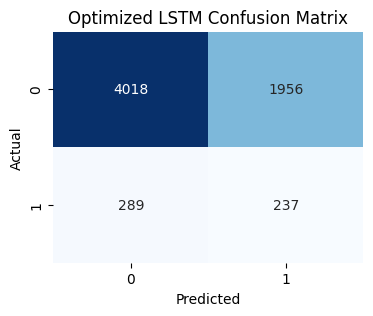

In [ ]:
probs = model.predict(X_test).ravel()
roc = roc_auc_score(y_test, probs)
prc = average_precision_score(y_test, probs)

thresholds = np.linspace(0.1, 0.9, 17)
best_f1 = 0
best_thresh = 0.5

for t in thresholds:
    p = (probs > t).astype(int)
    f1 = f1_score(y_test, p)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold for F1: {best_thresh:.2f} (F1: {best_f1:.4f})")
preds = (probs > best_thresh).astype(int)

print("\n**** FINAL METRICS, THRESHOLD OPTIMIZED ****")
print(f"Accuracy : {accuracy_score(y_test, preds):.4f}")
print(f"Precision: {precision_score(y_test, preds, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, preds, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, preds):.4f}")
print(f"ROC-AUC  : {roc:.4f}")
print(f"PR-AUC   : {prc:.4f}")
print(f"MSE      : {mean_squared_error(y_test, probs):.6f}")
print(f"MAE      : {mean_absolute_error(y_test, probs):.6f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_test, probs)):.6f}")
print(f"R² Score : {r2_score(y_test, probs):.4f}")

# 🧱 Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Optimized LSTM Confusion Matrix')
plt.show()


# **LSTM + Attention with Per-Feature Attention Weights**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

from imblearn.over_sampling import ADASYN  # ✅ This line fixes your error

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


df = pd.read_csv('credcardfrd50k.csv')

# Example features from transaction data
features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED'
]
label = 'isFraud'

df = df.dropna(subset=features + [label])
group_size = 10
df['user_id'] = df.index // group_size

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

sequence_length = 5
X_seq, y_seq = [], []

for _, user_df in df.groupby('user_id'):
    arr = user_df[features].values
    labs = user_df[label].values
    if len(arr) < (sequence_length + 1):
        continue
    for i in range(len(arr) - sequence_length):
        X_seq.append(arr[i:i+sequence_length])
        y_seq.append(labs[i+sequence_length-1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print(f"Sequences: {X_seq.shape}, Fraud: {np.sum(y_seq)}, Non-fraud: {len(y_seq) - np.sum(y_seq)}")


Sequences: (25000, 5, 8), Fraud: 2005, Non-fraud: 22995


In [ ]:
class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[-1],),
                                 initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        context = x * a
        if self.return_sequences:
            return context
        else:
            return K.sum(context, axis=1)


NameError: name 'Layer' is not defined

In [ ]:
# Load dataset
df = pd.read_csv("credcardfrd50k.csv")

features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED'
]
label = 'isFraud'

df = df.dropna(subset=features + [label])
df['user_id'] = df.index // 20

# Normalize
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


In [ ]:
SEQ_LEN = 7
X_seq, y_seq = [], []

for _, group in df.groupby('user_id'):
    vals = group[features].values
    labels = group[label].values
    if len(vals) < SEQ_LEN + 1:
        continue
    for i in range(len(vals) - SEQ_LEN):
        X_seq.append(vals[i:i+SEQ_LEN])
        y_seq.append(labels[i+SEQ_LEN-1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"✅ Built Sequences: {X_seq.shape}, Frauds: {int(np.sum(y_seq))}")


✅ Built Sequences: (32500, 7, 8), Frauds: 2631


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

# ADASYN
X_flat = X_train.reshape(X_train.shape[0], -1)
X_ada, y_ada = ADASYN(random_state=42).fit_resample(X_flat, y_train)
X_ada = X_ada.reshape(-1, SEQ_LEN, X_train.shape[2])
print("[+] After ADASYN:", np.bincount(y_ada.astype(int)))

# Undersample non-fraud
flat = X_ada.reshape(X_ada.shape[0], -1)
Xy = np.hstack([flat, y_ada.reshape(-1, 1)])
fraud = Xy[Xy[:, -1] == 1]
nonfraud = Xy[Xy[:, -1] == 0]
nonfraud_sampled = resample(nonfraud, n_samples=len(fraud), random_state=42)
balanced = np.vstack([fraud, nonfraud_sampled])
np.random.shuffle(balanced)

X_bal = balanced[:, :-1].reshape(-1, SEQ_LEN, X_train.shape[2])
y_bal = balanced[:, -1]

# Class weights
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_bal),
    y=y_bal
)
cw_dict = dict(enumerate(cw))
print("✅ After undersampling:", np.bincount(y_bal.astype(int)))


[+] After ADASYN: [23895 23289]
✅ After undersampling: [23289 23289]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Define Attention Layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], input_shape[-1]),
            initializer="random_normal",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True
        )
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        context = x * a
        if self.return_sequences:
            return context
        else:
            return K.sum(context, axis=1)

# 💡 Define the Model
SEQ_LEN = X_bal.shape[1]  # usually 5 or 7 based on your earlier code
NUM_FEATURES = X_bal.shape[2]

input_layer = Input(shape=(SEQ_LEN, NUM_FEATURES), name="Input")
x = Masking(mask_value=0.)(input_layer)
x = LSTM(64, return_sequences=True)(x)
x = BatchNormalization()(x)
attention = Attention(return_sequences=True, name="AttentionLayer")
x_att = attention(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x_att)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name="auc")])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'AttentionLayer' (of type Attention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 7, 8)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 7, 8)      │          0 │ Input[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 7, 8)      │          0 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 7)         │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 64)     │     18,688 │ masking_2[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 64)     │        256 │ lstm_2[0][0],     │
│ (BatchNormalizatio… │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AttentionLayer      │ (None, 7, 64)     │      4,160 │ batch_normalizat… │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ AttentionLayer[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,217 (98.50 KB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_bal, y_bal,
    validation_split=0.15,
    epochs=40,
    batch_size=128,
    class_weight=cw_dict,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/40
310/310 - 16s - 51ms/step - accuracy: 0.6436 - auc: 0.7059 - loss: 0.6251 - val_accuracy: 0.6423 - val_auc: 0.7984 - val_loss: 0.6159
Epoch 2/40
310/310 - 8s - 25ms/step - accuracy: 0.7564 - auc: 0.8287 - loss: 0.5049 - val_accuracy: 0.7752 - val_auc: 0.8526 - val_loss: 0.4718
Epoch 3/40
310/310 - 7s - 23ms/step - accuracy: 0.7903 - auc: 0.8642 - loss: 0.4489 - val_accuracy: 0.8006 - val_auc: 0.8746 - val_loss: 0.4322
Epoch 4/40
310/310 - 11s - 34ms/step - accuracy: 0.8041 - auc: 0.8764 - loss: 0.4276 - val_accuracy: 0.8025 - val_auc: 0.8795 - val_loss: 0.4197
Epoch 5/40
310/310 - 10s - 32ms/step - accuracy: 0.8078 - auc: 0.8844 - loss: 0.4150 - val_accuracy: 0.8104 - val_auc: 0.8912 - val_loss: 0.4100
Epoch 6/40
310/310 - 9s - 30ms/step - accuracy: 0.8171 - auc: 0.8939 - loss: 0.3975 - val_accuracy: 0.8201 - val_auc: 0.8967 - val_loss: 0.3905
Epoch 7/40
310/310 - 7s - 24ms/step - accuracy: 0.8264 - auc: 0.8991 - loss: 0.3870 - val_accuracy: 0.8262 - val_auc: 0.9001 - val_lo

In [ ]:
# Threshold tuning
probs = model.predict(X_test).ravel()
best_thresh, best_f1 = 0, 0
for t in np.linspace(0.1, 0.9, 17):
    preds_temp = (probs > t).astype(int)
    f1 = f1_score(y_test, preds_temp)
    if f1 > best_f1:
        best_thresh = t
        best_f1 = f1

preds = (probs > best_thresh).astype(int)

print(f"\n✅ Best Threshold: {best_thresh:.2f} | F1 Score: {best_f1:.4f}")
print(f"Accuracy : {accuracy_score(y_test, preds):.4f}")
print(f"Precision: {precision_score(y_test, preds):.4f}")
print(f"Recall   : {recall_score(y_test, preds):.4f}")
print(f"F1-score : {f1_score(y_test, preds):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, probs):.4f}")
print(f"PR-AUC   : {average_precision_score(y_test, probs):.4f}")


204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

✅ Best Threshold: 0.10 | F1 Score: 0.1500
Accuracy : 0.6914
Precision: 0.0965
Recall   : 0.3365
F1-score : 0.1500
ROC-AUC  : 0.5515
PR-AUC   : 0.0904


In [ ]:
# Create a model to output attention weights
att_model = Model(inputs=model.input,
                  outputs=model.get_layer("AttentionLayer").output)

# Run the model on test data
att_outputs = att_model.predict(X_test)  # shape: (samples, timesteps, features)

# Mean attention weight over all sequences and timesteps
att_mean = np.mean(att_outputs, axis=(0, 1))  # shape: (features,)

print("\n🔍 Feature Importance (via Attention):")
for i, feat in enumerate(features):
    print(f"{feat:>25}: {att_mean[i]:.4f}")


 13/204 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'AttentionLayer' (of type Attention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

🔍 Feature Importance (via Attention):
             CNT_CHILDREN: 0.0215
         AMT_INCOME_TOTAL: 0.0472
               AMT_CREDIT: 0.0234
              AMT_ANNUITY: -0.0170
          AMT_GOODS_PRICE: -0.0726
REGION_POPULATION_RELATIVE: -0.0467
               DAYS_BIRTH: -0.0328
            DAYS_EMPLOYED: -0.0245


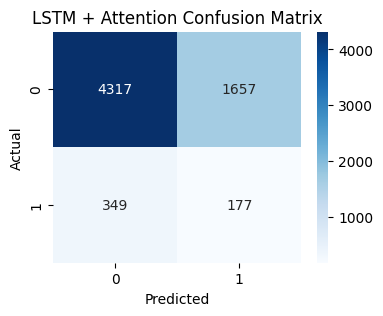

In [ ]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("LSTM + Attention Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
att_model = Model(inputs=model.input, outputs=model.get_layer("AttentionLayer").output)
att_outputs = att_model.predict(X_test)  # Shape: (samples, timesteps, features)
# Add this line to see the values
print(att_outputs)


204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
[[[ 3.83554846e-02  1.94759818e-03  1.51126742e-01 ...  7.68488273e-02
    5.69609821e-01 -2.36522313e-02]
  [-6.04681075e-02 -4.00629174e-03  6.75703660e-02 ...  3.74051854e-02
   -3.36094975e-01  7.20363930e-02]
  [-4.38271053e-02  3.92745733e-02  1.67153358e-01 ... -5.60584012e-03
   -6.21567607e-01 -5.11368401e-02]
  ...
  [-1.92896828e-01 -3.39199960e-01  1.16292626e-01 ... -2.43526027e-02
   -1.26421079e-01 -8.64565745e-02]
  [ 9.11194757e-02 -1.93537161e-01  3.20875011e-02 ... -5.92499785e-02
    9.94429961e-02  1.56521991e-01]
  [-5.09449005e-01 -5.49412310e-01 -5.14397137e-02 ... -7.00148225e-01
   -3.98537852e-02  1.27635717e-01]]

 [[ 2.70074636e-01  6.39674300e-03  2.65654698e-02 ...  1.66444197e-01
    1.30044445e-01  1.16827212e-01]
  [ 2.83914745e-01  5.23561500e-02  2.68192030e-02 ...  1.01926103e-01
    9.10239667e-02  2.04897419e-01]
  [ 1.15320936e-01  5.44059351e-02  5.11690900e-02 ...  7.54661188e-02
    1.45916045e-01  4.5

In [ ]:
print("Shape of attention outputs:", att_outputs.shape)


Shape of attention outputs: (6500, 7, 64)


In [ ]:
import numpy as np

# Assume 'features' is your ordered list of feature names (8 features total)
# Your custom Attention layer must be named "AttentionLayer" in your model.

from tensorflow.keras.models import Model

# Build a sub-model to output attention layer results
att_model = Model(
    inputs=model.input,
    outputs=model.get_layer("AttentionLayer").output
)

# Get the attended representations for your test set
att_outputs = att_model.predict(X_test)  # Shape: (samples, timesteps, features)

# Calculate the mean attention weight for each feature across all samples and timesteps
# (Aggregate as: mean over first (samples) and second (timesteps) axis)
att_mean = np.mean(att_outputs, axis=(0, 1))  # Shape: (features,)

# Print or save the feature importances
print("\n🔍 Feature Importance (via Attention):")
# Use the length of att_mean for iteration instead of sorted_idx,
# as sorted_idx might contain indices from a larger dimension if the attention output shape is different.
for i in range(len(att_mean)):
    print(f"{features[i]:>25}: {att_mean[i]:.4f}")

# Optionally, show as a sorted list:
# Ensure the sorted_idx is limited to the actual number of features corresponding to the attention output dimension.
num_att_features = att_mean.shape[0]
sorted_idx = np.argsort(-np.abs(att_mean))[:num_att_features]
print("\nTop Features Selected by Attention:")
for i in sorted_idx:
    # Ensure the index is valid for the 'features' list
    if i < len(features):
        print(f"{features[i]:>25}: {att_mean[i]:.4f}")

  9/204 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'AttentionLayer' (of type Attention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

🔍 Feature Importance (via Attention):
             CNT_CHILDREN: 0.0215
         AMT_INCOME_TOTAL: 0.0472
               AMT_CREDIT: 0.0234
              AMT_ANNUITY: -0.0170
          AMT_GOODS_PRICE: -0.0726
REGION_POPULATION_RELATIVE: -0.0467
               DAYS_BIRTH: -0.0328
            DAYS_EMPLOYED: -0.0245


IndexError: list index out of range

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, return_attention=True, **kwargs):
        self.return_attention = return_attention
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)        # alignment scores
        a = K.softmax(e, axis=1)                     # attention weights
        context = a * x                              # apply attention

        if self.return_attention:
            return [context, a]  # Return both
        else:
            return context



In [ ]:
from tensorflow.keras.layers import Input, LSTM, Masking, BatchNormalization, Dropout, Dense
import tensorflow as tf

SEQ_LEN = X_bal.shape[1]
N_FEATURES = X_bal.shape[2]

input_layer = Input(shape=(SEQ_LEN, N_FEATURES), name='Input')
x = Masking(mask_value=0.)(input_layer)
lstm_output = LSTM(64, return_sequences=True)(x)
lstm_output = BatchNormalization()(lstm_output)


In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, return_attention=False, return_sequences=True, **kwargs):
        self.return_attention = return_attention
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)               # shape: (batch, timesteps, features)

        context = x * a                        # apply weights to LSTM output

        if self.return_attention:
            return [context, a]               # Return both context and attention weights
        if self.return_sequences:
            return context                    # Return attended sequence
        else:
            return K.sum(context, axis=1)     # Return single pooled vector


In [ ]:
# Build model with both outputs
attention_layer = Attention(return_attention=True, name="AttentionLayer")
context_output, att_weights = attention_layer(lstm_output)  # Unpack list

# Continue with rest of model based on `context_output`
pooled = tf.keras.layers.GlobalAveragePooling1D()(context_output)
x = Dropout(0.3)(pooled)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model has 2 outputs now (main + attention)
full_model = Model(inputs=input_layer, outputs=[output, att_weights])

# During compile/training you can ignore the attention output:
full_model.compile(optimizer='adam',
                   loss={'dense': 'binary_crossentropy', 'AttentionLayer': lambda y_true, y_pred: 0},
                   metrics={'dense': ['accuracy', tf.keras.metrics.AUC()]})


In [ ]:
input_layer = Input(shape=(SEQ_LEN, N_FEATURES), name='Input')
x = Masking(mask_value=0.)(input_layer)
lstm_output = LSTM(64, return_sequences=True)(x)
lstm_output = BatchNormalization()(lstm_output)

# Use the corrected version with return_attention
attention_layer = Attention(return_attention=True, name="AttentionLayer")
context_output, att_weights = attention_layer(lstm_output)

# Continue building from context_output
pooled = tf.keras.layers.GlobalAveragePooling1D()(context_output)
x = Dropout(0.3)(pooled)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid', name='fraud_output')(x)

# Multi-output model: fraud prediction and attention weights
full_model = tf.keras.models.Model(inputs=input_layer, outputs=[output, att_weights])


In [ ]:
full_model.compile(
    optimizer='adam',
    loss={
        "fraud_output": "binary_crossentropy",
        "AttentionLayer": lambda y_true, y_pred: 0.0  # ignore in loss
    },
    metrics={
        "fraud_output": [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc')
        ]
    }
)


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
full_model.fit(
    X_bal, {"fraud_output": y_bal},  # y for final output only
    validation_split=0.15,
    epochs=30,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/30


ValueError: y_true and y_pred have different structures.
y_true: {'fraud_output': '*'}
y_pred: ['*', '*']


In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)  # Softmax over time steps (axis=1)
        self.attention_scores = a  # 🔥 store attention weights for interpretability
        context = x * a
        if self.return_sequences:
            return context
        else:
            return K.sum(context, axis=1)


In [ ]:
from tensorflow.keras.models import Model
import numpy as np

# List of input features (must match training)
features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED'
]

# Extract attention scores (this is different from attention outputs)
# ⚠️ 'attention_layer' must refer to the Attention() instance you used in your model before
att_extractor = Model(inputs=model.input, outputs=attention.attention_scores)

# Run test data through attention extractor
att_weights = att_extractor.predict(X_test)  # Shape: (samples, timesteps, features)
print("✅ Attention Weights Shape:", att_weights.shape)


AttributeError: 'Attention' object has no attribute 'attention_scores'

# **BiLSTM**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('credcardfrd50k.csv')

# Define features and label
features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED'
]
label = 'isFraud'

# Drop incomplete rows and standardize features
df = df.dropna(subset=features + [label])
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Create synthetic user sessions for sequential modeling
group_size = 20  # Increase for more context
df['user_id'] = df.index // group_size

# Create sequences
seq_len = 7
X_seq, y_seq = [], []
for _, user_df in df.groupby('user_id'):
    arr = user_df[features].values
    labs = user_df[label].values
    if len(arr) < seq_len + 1:
        continue
    for i in range(len(arr) - seq_len):
        X_seq.append(arr[i:i + seq_len])
        y_seq.append(labs[i + seq_len - 1])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)


In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.utils import class_weight, resample

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

# ADASYN oversampling (reshape for tabular over-sampling)
flat_train = X_train.reshape(X_train.shape[0], -1)
X_os, y_os = ADASYN(random_state=42).fit_resample(flat_train, y_train)
X_os = X_os.reshape(-1, seq_len, len(features))

# Optional: undersample non-fraud class after ADASYN for stronger balance
combined = np.hstack([X_os.reshape(X_os.shape[0], -1), y_os.reshape(-1, 1)])
fraud = combined[combined[:, -1] == 1]
nonfraud = combined[combined[:, -1] == 0]
nonfraud_downsampled = resample(nonfraud, n_samples=len(fraud), random_state=42)
final = np.vstack([fraud, nonfraud_downsampled])
np.random.shuffle(final)

X_bal = final[:, :-1].reshape(-1, seq_len, len(features))
y_bal = final[:, -1]

# Class weights
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_bal),
    y=y_bal
)
cw_dict = dict(enumerate(cw))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Masking, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

input_layer = Input(shape=(seq_len, len(features)), name="Input")
x = Masking(mask_value=0.)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(32))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_bal, y_bal,
    validation_split=0.15,
    epochs=40,
    batch_size=128,
    class_weight=cw_dict,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/40
310/310 - 28s - 91ms/step - accuracy: 0.6714 - auc: 0.7343 - loss: 0.6043 - val_accuracy: 0.5543 - val_auc: 0.8102 - val_loss: 0.7020
Epoch 2/40
310/310 - 19s - 60ms/step - accuracy: 0.7673 - auc: 0.8450 - loss: 0.4826 - val_accuracy: 0.7915 - val_auc: 0.8721 - val_loss: 0.4397
Epoch 3/40
310/310 - 20s - 63ms/step - accuracy: 0.8046 - auc: 0.8845 - loss: 0.4187 - val_accuracy: 0.8240 - val_auc: 0.9069 - val_loss: 0.3870
Epoch 4/40
310/310 - 21s - 68ms/step - accuracy: 0.8242 - auc: 0.9052 - loss: 0.3813 - val_accuracy: 0.8264 - val_auc: 0.9082 - val_loss: 0.3762
Epoch 5/40
310/310 - 20s - 66ms/step - accuracy: 0.8411 - auc: 0.9196 - loss: 0.3530 - val_accuracy: 0.8646 - val_auc: 0.9315 - val_loss: 0.3273
Epoch 6/40
310/310 - 15s - 49ms/step - accuracy: 0.8579 - auc: 0.9325 - loss: 0.3243 - val_accuracy: 0.8679 - val_auc: 0.9453 - val_loss: 0.3017
Epoch 7/40
310/310 - 22s - 72ms/step - accuracy: 0.8747 - auc: 0.9466 - loss: 0.2890 - val_accuracy: 0.8918 - val_auc: 0.9553 - va

204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step

Best Threshold: 0.10 | F1: 0.1412
Accuracy :  0.7774
Precision:  0.1027
Recall   :  0.2262
F1-score :  0.1412
ROC-AUC  :  0.5487
PR-AUC   :  0.0945


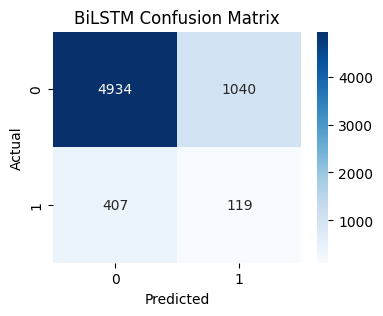

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

probs = model.predict(X_test).ravel()
best_f1, best_thresh = 0, 0.5
for t in np.linspace(0.1, 0.9, 17):
    preds = (probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_thresh, best_f1 = t, f1

preds = (probs > best_thresh).astype(int)

print(f"\nBest Threshold: {best_thresh:.2f} | F1: {best_f1:.4f}")
print(f"Accuracy :  {accuracy_score(y_test, preds):.4f}")
print(f"Precision:  {precision_score(y_test, preds):.4f}")
print(f"Recall   :  {recall_score(y_test, preds):.4f}")
print(f"F1-score :  {f1_score(y_test, preds):.4f}")
print(f"ROC-AUC  :  {roc_auc_score(y_test, probs):.4f}")
print(f"PR-AUC   :  {average_precision_score(y_test, probs):.4f}")

cm = confusion_matrix(y_test, preds)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BiLSTM Confusion Matrix")
plt.show()


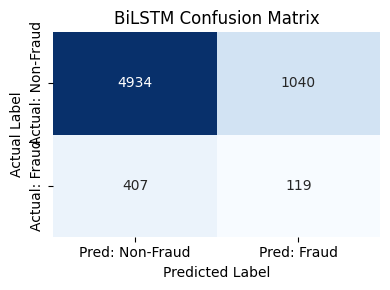

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Non-Fraud', 'Pred: Fraud'],
            yticklabels=['Actual: Non-Fraud', 'Actual: Fraud'])
plt.title("BiLSTM Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()


# **BiLSTM+SAP**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('credcardfrd50k.csv')

# Define features and label
features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED'
]
label = 'isFraud'

# Drop incomplete rows and standardize features
df = df.dropna(subset=features + [label])
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Create synthetic user sessions for sequential modeling
group_size = 20  # Increase for more context
df['user_id'] = df.index // group_size

# Create sequences
seq_len = 7
X_seq, y_seq = [], []
for _, user_df in df.groupby('user_id'):
    arr = user_df[features].values
    labs = user_df[label].values
    if len(arr) < seq_len + 1:
        continue
    for i in range(len(arr) - seq_len):
        X_seq.append(arr[i:i + seq_len])
        y_seq.append(labs[i + seq_len - 1])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)


In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.utils import class_weight, resample

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)

# ADASYN oversampling (reshape for tabular over-sampling)
flat_train = X_train.reshape(X_train.shape[0], -1)
X_os, y_os = ADASYN(random_state=42).fit_resample(flat_train, y_train)
X_os = X_os.reshape(-1, seq_len, len(features))

# Optional: undersample non-fraud class after ADASYN for stronger balance
combined = np.hstack([X_os.reshape(X_os.shape[0], -1), y_os.reshape(-1, 1)])
fraud = combined[combined[:, -1] == 1]
nonfraud = combined[combined[:, -1] == 0]
nonfraud_downsampled = resample(nonfraud, n_samples=len(fraud), random_state=42)
final = np.vstack([fraud, nonfraud_downsampled])
np.random.shuffle(final)

X_bal = final[:, :-1].reshape(-1, seq_len, len(features))
y_bal = final[:, -1]

# Class weights
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_bal),
    y=y_bal
)
cw_dict = dict(enumerate(cw))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Masking, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

input_layer = Input(shape=(seq_len, len(features)), name="Input")
x = Masking(mask_value=0.)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(32))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_bal, y_bal,
    validation_split=0.15,
    epochs=40,
    batch_size=128,
    class_weight=cw_dict,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/40
310/310 - 41s - 131ms/step - accuracy: 0.6644 - auc: 0.7278 - loss: 0.6151 - val_accuracy: 0.5673 - val_auc: 0.7856 - val_loss: 0.7276
Epoch 2/40
310/310 - 14s - 46ms/step - accuracy: 0.7632 - auc: 0.8398 - loss: 0.4912 - val_accuracy: 0.7832 - val_auc: 0.8717 - val_loss: 0.4540
Epoch 3/40
310/310 - 14s - 46ms/step - accuracy: 0.8010 - auc: 0.8779 - loss: 0.4303 - val_accuracy: 0.8284 - val_auc: 0.9078 - val_loss: 0.3811
Epoch 4/40
310/310 - 21s - 68ms/step - accuracy: 0.8185 - auc: 0.8989 - loss: 0.3941 - val_accuracy: 0.8237 - val_auc: 0.9040 - val_loss: 0.3904
Epoch 5/40
310/310 - 15s - 47ms/step - accuracy: 0.8367 - auc: 0.9132 - loss: 0.3660 - val_accuracy: 0.8522 - val_auc: 0.9289 - val_loss: 0.3360
Epoch 6/40
310/310 - 21s - 68ms/step - accuracy: 0.8504 - auc: 0.9249 - loss: 0.3417 - val_accuracy: 0.8678 - val_auc: 0.9398 - val_loss: 0.3095
Epoch 7/40
310/310 - 14s - 46ms/step - accuracy: 0.8587 - auc: 0.9347 - loss: 0.3195 - val_accuracy: 0.8763 - val_auc: 0.9468 - v

204/204 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step

Best Threshold: 0.10 | F1: 0.1224
Accuracy :  0.7926
Precision:  0.0931
Recall   :  0.1787
F1-score :  0.1224
ROC-AUC  :  0.5446
PR-AUC   :  0.0920


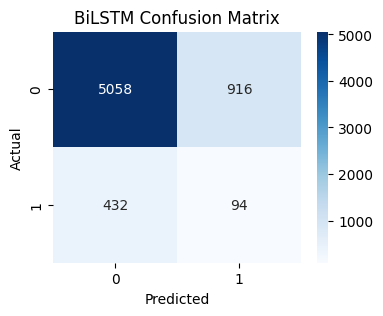

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

probs = model.predict(X_test).ravel()
best_f1, best_thresh = 0, 0.5
for t in np.linspace(0.1, 0.9, 17):
    preds = (probs > t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_thresh, best_f1 = t, f1

preds = (probs > best_thresh).astype(int)

print(f"\nBest Threshold: {best_thresh:.2f} | F1: {best_f1:.4f}")
print(f"Accuracy :  {accuracy_score(y_test, preds):.4f}")
print(f"Precision:  {precision_score(y_test, preds):.4f}")
print(f"Recall   :  {recall_score(y_test, preds):.4f}")
print(f"F1-score :  {f1_score(y_test, preds):.4f}")
print(f"ROC-AUC  :  {roc_auc_score(y_test, probs):.4f}")
print(f"PR-AUC   :  {average_precision_score(y_test, probs):.4f}")

cm = confusion_matrix(y_test, preds)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BiLSTM Confusion Matrix")
plt.show()


# **LSTM From ChatGPT**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv("credcardfrd50k.csv")
print(df.head())
print(df.info())


   TransactionID  isFraud  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0         130196        0             0           94500.0    180000.0   
1         277776        0             1          108000.0    227520.0   
2         231918        0             0          166500.0    490500.0   
3         327409        0             0          225000.0   1436850.0   
4         276356        0             0          171000.0    163008.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       9000.0         180000.0                    0.008575      -19671   
1      16618.5         180000.0                    0.009630      -12947   
2      30136.5         490500.0                    0.015221      -23013   
3      42142.5        1125000.0                    0.020713      -19845   
4      17685.0         144000.0                    0.016612      -14371   

   DAYS_EMPLOYED  ...   ERC20 most sent token type_0  \
0          -9266  ...                              0  

In [ ]:
print(df.columns)
target_col = 'isFraud'  # ✅ Corrected

# Separate features and target
features = df.drop(columns=[target_col])
labels = df[target_col]


Index(['TransactionID', 'isFraud', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       ' ERC20 most sent token type_0', ' ERC20 most sent token type_EOS',
       ' ERC20 most sent token type_Golem',
       ' ERC20 most sent token type_OmiseGO',
       ' ERC20 most sent token type_Others',
       ' ERC20_most_rec_token_type_Blockwell say NOTSAFU',
       ' ERC20_most_rec_token_type_DATAcoin',
       ' ERC20_most_rec_token_type_Livepeer Token',
       ' ERC20_most_rec_token_type_OmiseGO',
       ' ERC20_most_rec_token_type_Others'],
      dtype='object', length=381)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

target_col = 'isFraud'  # ✅ Correct column name
features = df.drop(columns=[target_col])
labels = df[target_col]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)


In [ ]:
def create_sequences(data, labels, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_features, labels.values, sequence_length)
print(X.shape, y.shape)  # Expecting shape: (samples, time_steps, features)


(49990, 10, 380) (49990,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,801 (81.25 KB)

 Trainable params: 20,801 (81.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight={0:1, 1:50},  # To handle class imbalance
    verbose=1
)


Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.1350 - auc: 0.5367 - loss: 2.6394 - val_accuracy: 0.0809 - val_auc: 0.6077 - val_loss: 1.3311
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0795 - auc: 0.5911 - loss: 2.3301 - val_accuracy: 0.0809 - val_auc: 0.6187 - val_loss: 1.5432
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0814 - auc: 0.5947 - loss: 2.3411 - val_accuracy: 0.0811 - val_auc: 0.6238 - val_loss: 1.5652
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0814 - auc: 0.5942 - loss: 2.3364 - val_accuracy: 0.0812 - val_auc: 0.6258 - val_loss: 1.6263
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0851 - auc: 0.6124 - loss: 2.3289 - val_accuracy: 0.0811 - val_auc: 0.6253 - val_loss: 1.4453
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0816 - auc: 0.6106 - loss: 2.3202 - val_accuracy: 0.0811 - val_auc: 0.6271 - val_loss: 1.5575
Epoch 7/10
407/407 ━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[[  25 5949]
 [   0  526]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      5974
           1       0.08      1.00      0.15       526

    accuracy                           0.08      6500
   macro avg       0.54      0.50      0.08      6500
weighted avg       0.93      0.08      0.02      6500



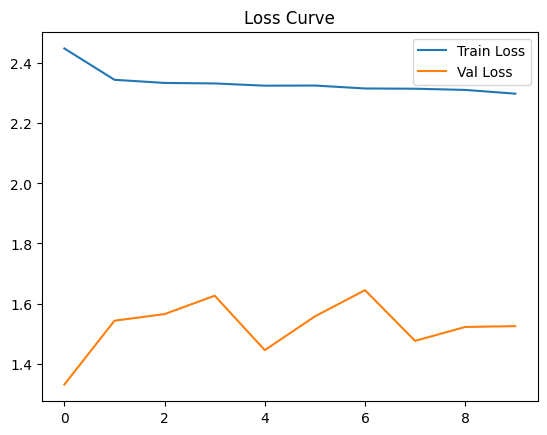

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


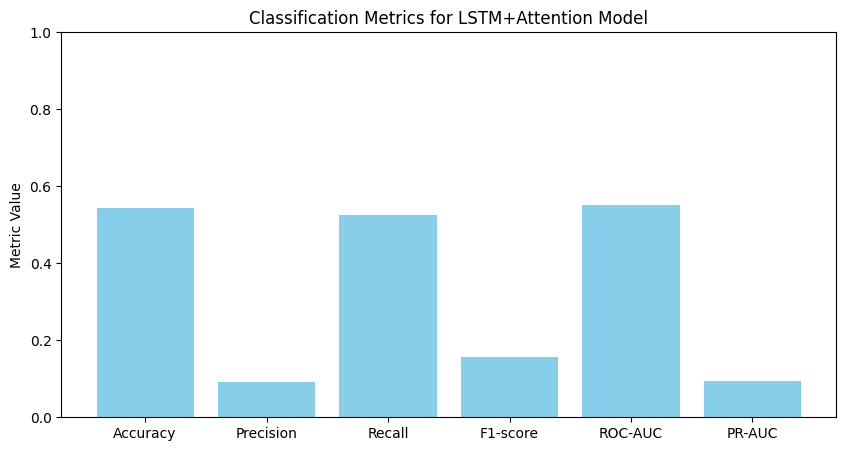

In [ ]:
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC']
values = [0.5434, 0.0922, 0.5247, 0.1568, 0.5507, 0.0931]  # Example values

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color='skyblue')
plt.title('Classification Metrics for LSTM+Attention Model')
plt.ylabel('Metric Value')
plt.ylim(0, 1)
plt.show()


In [ ]:
import numpy as np

models = ['LSTM+Attention', 'BiLSTM', 'SAP BiLSTM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC']
values = [
    [0.5434, 0.0922, 0.5247, 0.1568, 0.5507, 0.0931],
    [0.7820, 0.1012, 0.2148, 0.1376, 0.5530, 0.0962],
    [0.7926, 0.0931, 0.1787, 0.1224, 0.5446, 0.0920]
]


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

from imblearn.over_sampling import ADASYN  # ✅ This line fixes your error

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


df = pd.read_csv('credcardfrd50k.csv')

# Example features from transaction data
features = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED'
]
label = 'isFraud'

df = df.dropna(subset=features + [label])
group_size = 10
df['user_id'] = df.index // group_size

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

sequence_length = 5
X_seq, y_seq = [], []

for _, user_df in df.groupby('user_id'):
    arr = user_df[features].values
    labs = user_df[label].values
    if len(arr) < (sequence_length + 1):
        continue
    for i in range(len(arr) - sequence_length):
        X_seq.append(arr[i:i+sequence_length])
        y_seq.append(labs[i+sequence_length-1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
print(f"Sequences: {X_seq.shape}, Fraud: {np.sum(y_seq)}, Non-fraud: {len(y_seq) - np.sum(y_seq)}")


Sequences: (25000, 5, 8), Fraud: 2005, Non-fraud: 22995
